In [1]:
# Setting up packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from styles.colors import get_colors
from scipy import stats
import re
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Colors
ARDS_COLORS = get_colors("ards")
COLOR = get_colors("palette")
COLORS_SEQUENTIAL_TEAL = get_colors("sequential_teal")
COLORS_SEQUENTIAL_ORANGE = get_colors("sequential_orange")

# Clean data

In [2]:
# Cleaning data
df_org = pd.read_csv('clean_dat.csv')
mask_sepsis = df_org['Sepsis'] == True
df1 = df_org.loc[mask_sepsis].copy()
mask_mild_ards = (
    (df1['ards_severity'] == 'Mild') |
    (df1['ards_mild'] == True) |
    (df1['ards_notmild'] == False)
)
mask_remove = (df1['ards'] == True) & mask_mild_ards
data = df1.loc[~mask_remove].copy()

# Remove ards na patient
data = data[~data['ards'].isna()]

/var/folders/rz/3cfhhdrd2bs65msqx2gtqcph0000gn/T/ipykernel_87183/1311144541.py:2: DtypeWarning: Columns (0: SampleNotes, 1: AssayNotes) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv('clean_dat.csv')


In [3]:
protein_cols = [c for c in data.columns if re.match(r"^seq", str(c))] 

# T-tests

In [4]:
# -----------------------------
# T-tests
# -----------------------------
rows = []
mask1 = data["ards"] == 1
mask0 = data["ards"] == 0

for prot in protein_cols:
    g1 = data.loc[mask1, prot].astype(float)
    g0 = data.loc[mask0, prot].astype(float)

    # Mean difference (ARDS - non-ARDS), ignoring NaNs
    mean_diff = np.nanmean(g1) - np.nanmean(g0)

    # Welch t-test, omit NaNs
    # (equivalent spirit to R t.test default)
    try:
        t = stats.ttest_ind(g1, g0, equal_var=False, nan_policy="omit")
        pval = float(t.pvalue)
    except Exception:
        pval = np.nan

    if not np.isnan(pval):
        rows.append({"Protein": prot, "MeanDiff": mean_diff, "pval": pval})

results = pd.DataFrame(rows)

# -----------------------------
# Multiple testing correction
# -----------------------------
CORRECTION_METHOD = "fdr"  # "fdr" or "bonferroni"

method_map = {
    "fdr": "fdr_bh",         # Benjamini–Hochberg
    "bonferroni": "bonferroni"
}
mt_method = method_map.get(CORRECTION_METHOD.lower())
if mt_method is None:
    raise ValueError('CORRECTION_METHOD must be "fdr" or "bonferroni"')

_, adj_p, _, _ = multipletests(results["pval"].values, method=mt_method)
results["ADJ_P"] = adj_p

In [5]:
results.head()

,Protein,MeanDiff,pval,ADJ_P
0,seq.10000.28,-0.013586,0.425400,0.836974
1,seq.10001.7,-0.002147,0.856201,0.973656
2,seq.10003.15,-0.008912,0.431888,0.841121
3,seq.10006.25,0.013469,0.441214,0.847251
4,seq.10008.43,0.011027,0.649518,0.922017


In [6]:
ANNOT_PATH = "Attilas/somalogic_annotation.csv"  # e.g. "somalogic_annotation.csv"

# -----------------------------
# Fix PROBEID format (dot to dash), strip leading "seq."
# R: gsub("^seq\\.", "", Protein) then replace "123.45" -> "123-45"
# We'll do: remove leading "seq." OR "seq" then convert the first "digits.digits" to "digits-digits"
# -----------------------------
def protein_to_probeid(name: str) -> str:
    s = str(name)
    s = re.sub(r"^seq\.", "", s)
    s = re.sub(r"^seq", "", s)
    # Replace first occurrence of digits.digits with digits-digits
    s = re.sub(r"([0-9]+)\.([0-9]+)", r"\1-\2", s)
    return s

results["PROBEID"] = results["Protein"].map(protein_to_probeid)

# -----------------------------
# SomaScan Annotation (Python replacement)
# -----------------------------
if ANNOT_PATH is not None:
    annot = pd.read_csv(ANNOT_PATH)
    # Expect columns: PROBEID, SYMBOL, UNIPROT, GENENAME (case-sensitive here; adjust if needed)
    for col in ["PROBEID", "SYMBOL", "UNIPROT", "GENENAME"]:
        if col in annot.columns:
            annot[col] = annot[col].astype(str).replace({"nan": ""})
else:
    # No annotation provided; create empty columns so later code works
    annot = pd.DataFrame({"PROBEID": results["PROBEID"].unique()})
    annot["SYMBOL"] = ""
    annot["UNIPROT"] = ""
    annot["GENENAME"] = ""

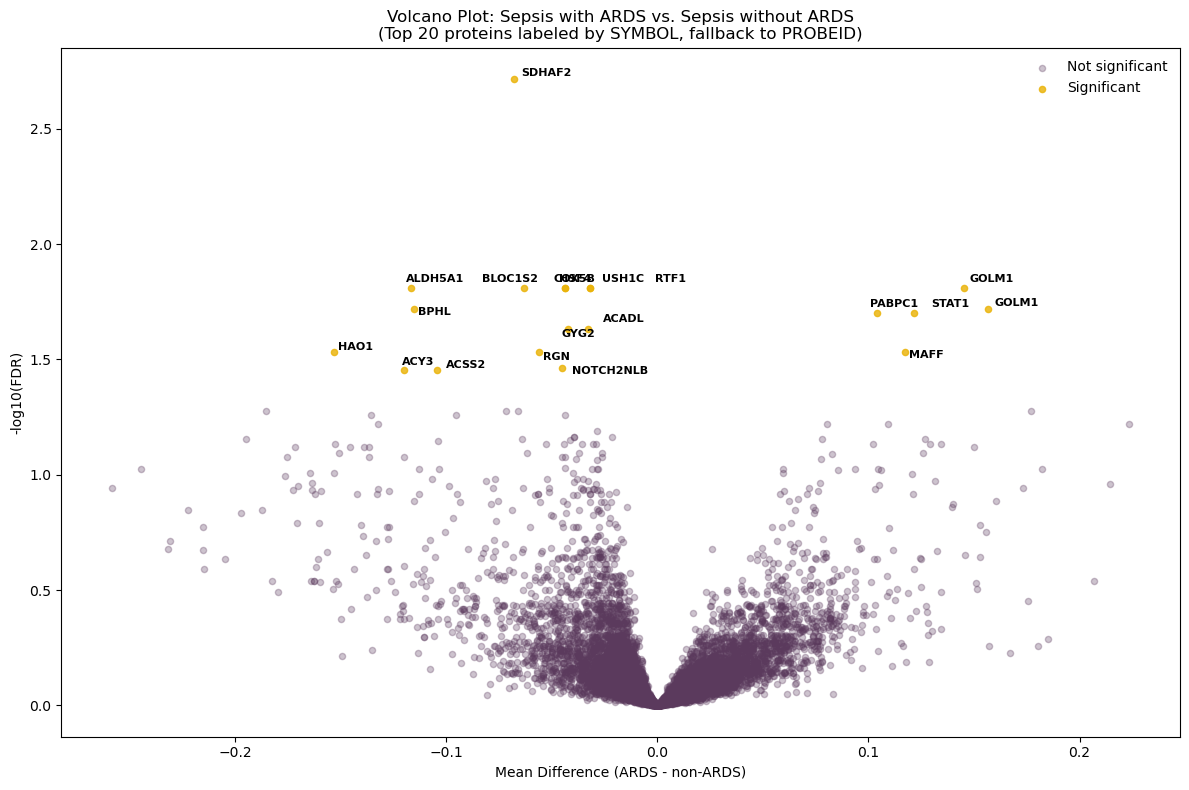

In [53]:
# Volcano plot
ALPHA_LABEL = 0.05
N_LABELS = 20

# -----------------------------
# Merge + deduplicate by Protein
# -----------------------------
volcano = results.merge(annot, on="PROBEID", how="left")

# Deduplicate by Protein (keep first)
volcano = volcano.drop_duplicates(subset=["Protein"]).reset_index(drop=True)

# Label: SYMBOL fallback to PROBEID
volcano["Label"] = np.where(
    volcano["SYMBOL"].notna() & (volcano["SYMBOL"].astype(str).str.strip() != "") & (volcano["SYMBOL"] != "nan"),
    volcano["SYMBOL"].astype(str),
    volcano["PROBEID"].astype(str),
)

# -----------------------------
# Top hits for labeling
# -----------------------------
sig_mask = volcano["ADJ_P"] < ALPHA_LABEL
top_hits = volcano.loc[sig_mask].copy()
if len(top_hits) > 0:
    top_hits = top_hits.sort_values("ADJ_P").head(N_LABELS)
else:
    top_hits = volcano.sort_values("ADJ_P").head(N_LABELS)

top_hits["Label"] = np.where(
    top_hits["SYMBOL"].notna() & (top_hits["SYMBOL"].astype(str).str.strip() != "") & (top_hits["SYMBOL"] != "nan"),
    top_hits["SYMBOL"].astype(str),
    top_hits["PROBEID"].astype(str),
)

# -----------------------------
# Volcano Plot (matplotlib + adjustText ~ ggrepel)
# -----------------------------
x = volcano["MeanDiff"].values
y = -np.log10(np.clip(volcano["ADJ_P"].values, 1e-300, 1.0))  # avoid log(0)

is_sig = volcano["ADJ_P"].values < ALPHA_LABEL

plt.figure(figsize=(12, 8))
plt.scatter(x[~is_sig], y[~is_sig], alpha=0.3, s=20, label="Not significant", color=COLOR['accent'])
plt.scatter(x[is_sig], y[is_sig], alpha=0.82, s=20, label="Significant", color = COLOR['warning'])

# Label points for top hits
texts = []
for _, r in top_hits.iterrows():
    tx = float(r["MeanDiff"])
    ty = -np.log10(max(float(r["ADJ_P"]), 1e-300))
    texts.append(plt.text(tx, ty, str(r["Label"]), fontsize=8, fontweight="bold"))

# Repel labels
adjust_text(texts)

y_label = "-log10(FDR)" if CORRECTION_METHOD.lower() == "fdr" else "-log10(Bonferroni adj. p)"
plt.xlabel("Mean Difference (ARDS - non-ARDS)")
plt.ylabel(y_label)
plt.title(
    f"Volcano Plot: Sepsis with ARDS vs. Sepsis without ARDS\n"
    f"(Top {N_LABELS} proteins labeled by SYMBOL, fallback to PROBEID)"
)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [45]:
sum(is_sig)

20

In [8]:
# List of the most significant according to adjusted p-value
top_significant = volcano.sort_values("ADJ_P").head(20)
print(top_significant[["PROBEID", "SYMBOL", "MeanDiff", "ADJ_P"]])

         PROBEID     SYMBOL  MeanDiff     ADJ_P
4712    26103-20     SDHAF2 -0.067854  0.001927
2168   17792-158    ALDH5A1 -0.116916  0.015538
2118    17725-37      USH1C -0.031879  0.015538
9729    7741-111       RTF1 -0.031781  0.015538
7359    33451-35       HSF4 -0.043828  0.015538
9828     7887-57      COX5B -0.043889  0.015538
10294     8983-7      GOLM1  0.145435  0.015538
3049     21184-1    BLOC1S2 -0.062963  0.015538
2183    17813-21       BPHL -0.115438  0.019190
2068    17456-53      GOLM1  0.156575  0.019190
661     12351-25      STAT1  0.121751  0.019955
7726    34205-12     PABPC1  0.104165  0.019955
4380    25066-32       GYG2 -0.042427  0.023303
2208     17857-6      ACADL -0.032900  0.023303
3764    23224-11        RGN -0.056120  0.029491
6559    31598-17       MAFF  0.117117  0.029491
2148    17768-50       HAO1 -0.153411  0.029491
7318     33381-1  NOTCH2NLB -0.045211  0.034381
4401     25094-9      ACSS2 -0.104558  0.035251
3332     21781-9       ACY3 -0.119802  0

# Klassificerare 

## Logistisk regression

In [29]:
k = 5

# Välj top-k proteiner (lägst ADJ_P)
top_proteins = (
    results.sort_values("ADJ_P")  
           .head(k)["Protein"]
           .tolist()
)

# Bygg X (patienter x proteiner) och y
X = data[top_proteins]
y = data["ards"]

#check for null values
print(y.isnull().sum())

#remove null values
mask = y.notnull()
y = y.loc[mask]
print(y.isnull().sum())
print(X.shape)
print(y.shape)


0
0
(408, 5)
(408,)


In [30]:
# Train/test split (stratifiera pga obalans)
y = data["ards"].map({False: 0, True: 1}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.value_counts(), y_test.value_counts())


(326, 5) (82, 5) (326,) (82,)
ards
0    274
1     52
Name: count, dtype: int64 ards
0    69
1    13
Name: count, dtype: int64


In [31]:

model_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=10000, solver="lbfgs", class_weight="balanced"))  # default L2 är ofta bra
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "auc": "roc_auc",
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "f1": "f1",
    "prec": "precision",
    "rec": "recall"
}

cv_res = cross_validate(
    model_lr,
    X_train, y_train,                      # hela datan
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

summary = pd.DataFrame(cv_res).drop(columns=["fit_time", "score_time"])
print("=== Cross-validation (5-fold) ===")
print(summary.agg(["mean", "std"]).T.sort_values("mean", ascending=False))

print("\nAUC mean ± std:",
      f"{summary['test_auc'].mean():.3f} ± {summary['test_auc'].std():.3f}")

# Holdout-test (X_train, y_train -> X_test, y_test)
model_lr.fit(X_train, y_train)

proba = model_lr.predict_proba(X_test)[:, 1]
pred  = model_lr.predict(X_test)

print("\n=== Holdout test-set evaluation ===")
print("AUC:", roc_auc_score(y_test, proba))
print("Accuracy:", accuracy_score(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

=== Cross-validation (5-fold) ===
                  mean       std
test_auc      0.719383  0.084883
test_rec      0.694545  0.092843
test_bal_acc  0.644714  0.055326
test_acc      0.610303  0.041403
test_f1       0.362552  0.047277
test_prec     0.245873  0.034073

AUC mean ± std: 0.719 ± 0.085

=== Holdout test-set evaluation ===
AUC: 0.6822742474916388
Accuracy: 0.5365853658536586
Confusion matrix:
 [[35 34]
 [ 4  9]]
              precision    recall  f1-score   support

           0      0.897     0.507     0.648        69
           1      0.209     0.692     0.321        13

    accuracy                          0.537        82
   macro avg      0.553     0.600     0.485        82
weighted avg      0.788     0.537     0.596        82



Korrigera för obalanserat dataset

In [32]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

model_lr_ros = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("oversample", RandomOverSampler(random_state=42)),
    ("clf", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"auc": "roc_auc", "bal_acc": "balanced_accuracy", "rec": "recall", "prec": "precision", "f1": "f1"}

cv_res = cross_validate(
    model_lr_ros, X, y,
    cv=cv, scoring=scoring, n_jobs=1
)

summary = pd.DataFrame(cv_res).drop(columns=["fit_time", "score_time"])
print(summary.agg(["mean", "std"]).T)

                  mean       std
test_auc      0.721077  0.065116
test_bal_acc  0.672195  0.074071
test_rec      0.723077  0.185255
test_prec     0.263402  0.036723
test_f1       0.384266  0.063713


In [33]:
import sklearn
print("sklearn:", sklearn.__version__)
import imblearn
print("imblearn:", imblearn.__version__)


sklearn: 1.7.1
imblearn: 0.14.1


In [34]:
from sklearn.calibration import cross_val_predict


model_lr_smote = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(k_neighbors=5, random_state=42)),
    ("clf", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"auc": "roc_auc", "bal_acc": "balanced_accuracy", "rec": "recall", "prec": "precision", "f1": "f1"}

cv_res = cross_validate(
    model_lr_smote, X, y,
    cv=cv, scoring=scoring, n_jobs=1
)

summary = pd.DataFrame(cv_res).drop(columns=["fit_time", "score_time"])
print(summary.agg(["mean", "std"]).T)

# Få out-of-fold predictions
y_pred = cross_val_predict(
    model_lr_smote,
    X_test, y_test,
    cv=cv,
    method="predict",
    n_jobs=1
)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix (cross-validated):")
print(cm)

                  mean       std
test_auc      0.713889  0.068165
test_bal_acc  0.663053  0.059430
test_rec      0.707692  0.147964
test_prec     0.259663  0.033338
test_f1       0.378175  0.053925
Confusion matrix (cross-validated):
[[41 28]
 [ 6  7]]


## Random Forest

In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")
     )
])

param_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [None, 3, 5, 10],
    "clf__min_samples_leaf": [2, 3, 5],
    "clf__max_features": ["sqrt", 0.5]   # 0.5 = 50% av features
}

grid = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,          # tränar om bästa modellen på hela train efter CV
    verbose=1
)

grid.fit(X_train, y_train)

print("Best CV AUC:", grid.best_score_)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

proba = best_model.predict_proba(X_test)[:, 1]
pred  = best_model.predict(X_test)

print("\n=== Holdout test-set evaluation (best RF from GridSearch) ===")
print("AUC:", roc_auc_score(y_test, proba))
print("Accuracy:", accuracy_score(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best CV AUC: 0.6615120906029996
Best params: {'clf__max_depth': 3, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 500}

=== Holdout test-set evaluation (best RF from GridSearch) ===
AUC: 0.6744704570791528
Accuracy: 0.5975609756097561
Confusion matrix:
 [[41 28]
 [ 5  8]]
              precision    recall  f1-score   support

           0      0.891     0.594     0.713        69
           1      0.222     0.615     0.327        13

    accuracy                          0.598        82
   macro avg      0.557     0.605     0.520        82
weighted avg      0.785     0.598     0.652        82



## XGBoost

In [36]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_xgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    ))
])

# Liten grid
param_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [2, 3, 4],
    "clf__learning_rate": [0.03, 0.1],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__reg_lambda": [1.0, 5.0],   # L2
    # hantera obalans (ca 343/65 ≈ 5.28)
    "clf__scale_pos_weight": [(y_train == 0).sum() / (y_train == 1).sum()]
}

grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

print("Best CV AUC:", grid_xgb.best_score_)
print("Best params:", grid_xgb.best_params_)

best_xgb = grid_xgb.best_estimator_

proba = best_xgb.predict_proba(X_test)[:, 1]
pred  = best_xgb.predict(X_test)

print("\n=== Holdout test-set evaluation (best XGB from GridSearch) ===")
print("AUC:", roc_auc_score(y_test, proba))
print("Accuracy:", accuracy_score(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best CV AUC: 0.6328864401591673
Best params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.03, 'clf__max_depth': 2, 'clf__n_estimators': 200, 'clf__reg_lambda': 1.0, 'clf__scale_pos_weight': 5.269230769230769, 'clf__subsample': 0.8}

=== Holdout test-set evaluation (best XGB from GridSearch) ===
AUC: 0.6711259754738015
Accuracy: 0.6463414634146342
Confusion matrix:
 [[44 25]
 [ 4  9]]
              precision    recall  f1-score   support

           0      0.917     0.638     0.752        69
           1      0.265     0.692     0.383        13

    accuracy                          0.646        82
   macro avg      0.591     0.665     0.568        82
weighted avg      0.813     0.646     0.694        82

